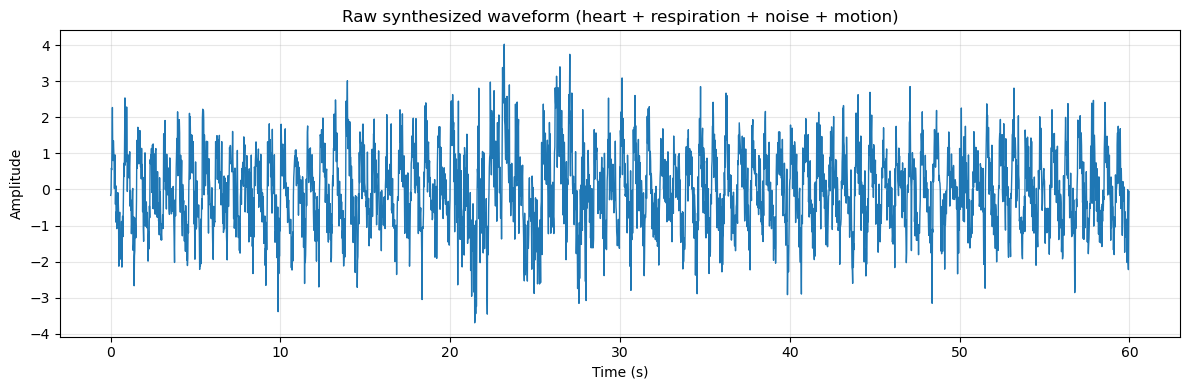

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# ===== 產生測試資料並分析 =====


def synth_mmwave_heartbeat(duration_s=60.0,
                           fs=50.0,
                           hr_bpm=78.0,          # 真實心率
                           rr_bpm=14.0,          # 呼吸率
                           amp=1.0,
                           snr_db=3.0,           # 白噪 SNR
                           motion_start_s=20.0,  # 移動雜訊區段
                           motion_end_s=28.0,
                           motion_snr_db=-3.0,   # 移動雜訊更強
                           seed=7):
    """
    產生 mmWave 胸部量測的簡化波形：
    - 心跳：基頻 + 第二、第三諧波（相位微調）
    - 呼吸：作為幅度與相位的低頻調變
    - 移動雜訊：在指定時間段加入寬頻/低頻混合雜訊
    - 白噪聲：全段加入
    回傳：與你的 analyze_* 相容的 summary dict
    """
    rng = np.random.default_rng(seed)
    N = int(duration_s * fs)
    t = np.arange(N) / fs

    # 心跳與呼吸參數
    hr_hz = hr_bpm / 60.0
    rr_hz = rr_bpm / 60.0

    # 呼吸作幅度與相位調變（AM+PM）
    resp_amp = 0.25 * (1 + 0.3 * rng.standard_normal())      # 幅度調變深度
    resp_pm  = 0.12 * (1 + 0.3 * rng.standard_normal())      # 相位調變深度
    resp     = np.sin(2*np.pi*rr_hz*t)

    # 心跳成分：基頻 + 2f + 3f，加入些微非線性相位
    phi_base = 2*np.pi*hr_hz*t + resp_pm * np.sin(2*np.pi*rr_hz*t)
    s1 = np.sin(phi_base + 0.05*np.sin(2*np.pi*3*hr_hz*t))
    s2 = 0.45*np.sin(2*phi_base + 0.03*np.sin(2*np.pi*2*hr_hz*t + 0.7))
    s3 = 0.25*np.sin(3*phi_base + 0.02*np.sin(2*np.pi*1*hr_hz*t + 1.3))
    heart = amp * (1 + resp_amp * resp) * (s1 + s2 + s3)

    # 白噪：設定全段 SNR
    sig_pow = np.mean(heart**2)
    noise_pow = sig_pow / (10**(snr_db/10))
    white = rng.normal(0, np.sqrt(noise_pow), size=N)

    # 移動雜訊：指定時間段，寬帶+低頻混合
    motion = np.zeros(N)
    idx = (t >= motion_start_s) & (t <= motion_end_s)
    if idx.any():
        L = idx.sum()
        # 寬帶
        motion_white = rng.normal(0, 1.0, size=L)
        # 低頻（模擬姿態/說話）
        f_low = 0.3  # Hz
        motion_low = np.sin(2*np.pi*f_low*np.arange(L)/fs + 2.0)
        motion_seg = 0.7*motion_white + 1.4*motion_low
        # 按 motion_snr_db 設能量
        seg_pow = np.mean((heart[idx])**2)
        mot_pow = seg_pow / (10**(motion_snr_db/10))
        motion[idx] = motion_seg / np.std(motion_seg) * np.sqrt(mot_pow)

    x = heart + white + motion

    # 與你的函式相容的 summary
    df = pd.DataFrame({"t_sec": t, "heartbeat": x})
    summary = {
        "dataframe": df,
        "fs_Hz": fs,
        "csv": "outputs/heart_rate_series.csv",  # 供你的路徑處理用
        "est_hr_bpm": hr_bpm                     # 當作參考線
    }
    return summary

def plot_raw_waveform(summary, outdir=None):
    df = summary['dataframe']
    t = df['t_sec'].values
    x = df['heartbeat'].values

    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')
    os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(12,4))
    plt.plot(t, x, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Raw synthesized waveform (heart + respiration + noise + motion)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(os.path.join(outdir, "raw_waveform.png"), dpi=200)
    plt.show()
summary = synth_mmwave_heartbeat(
    duration_s=60.0,
    fs=50.0,
    hr_bpm=78.0,
    rr_bpm=14.0,
    snr_db=2.0,            # 故意偏低，考驗魯棒性
    motion_start_s=20.0,
    motion_end_s=28.0,
    motion_snr_db=-2.0
)
# 使用
plot_raw_waveform(summary)

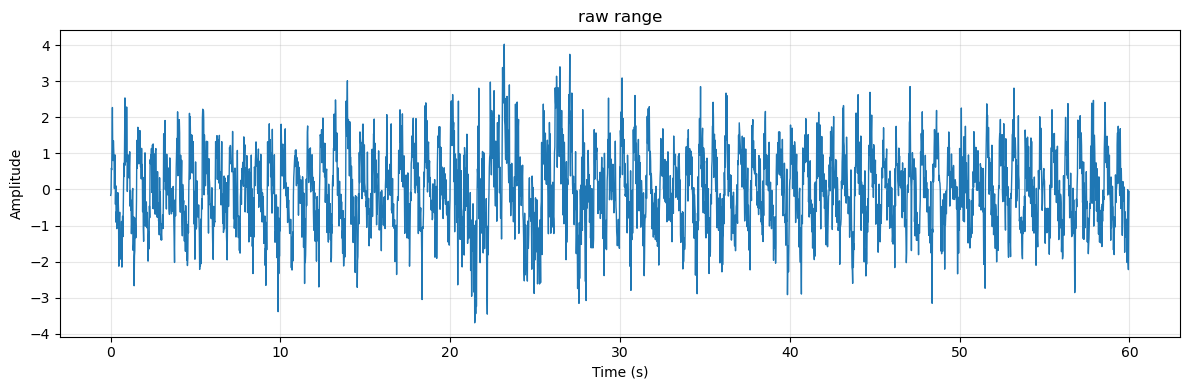

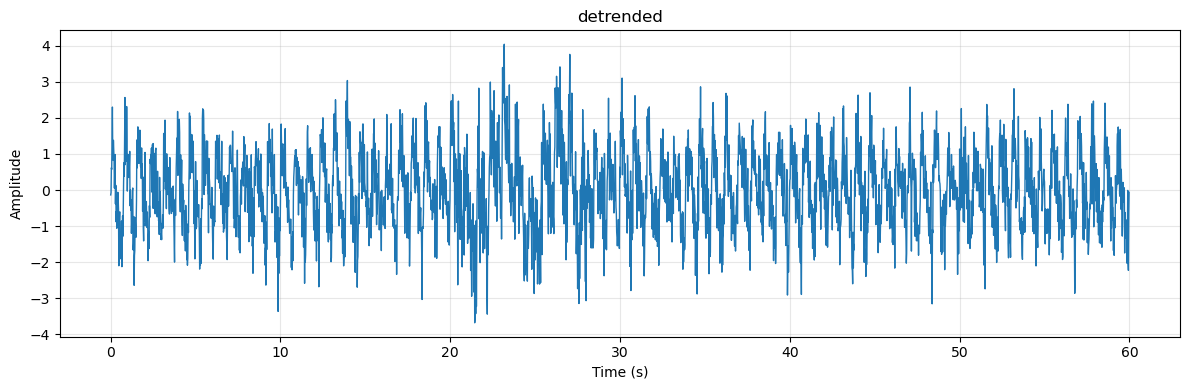

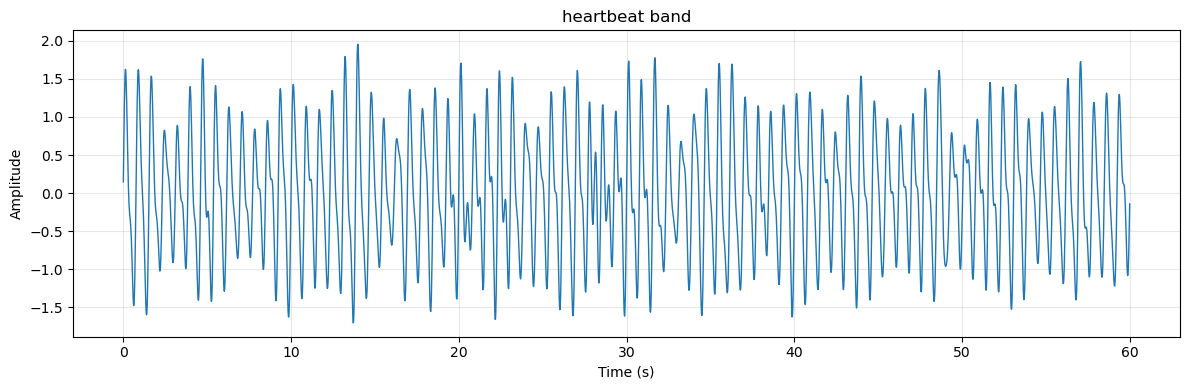

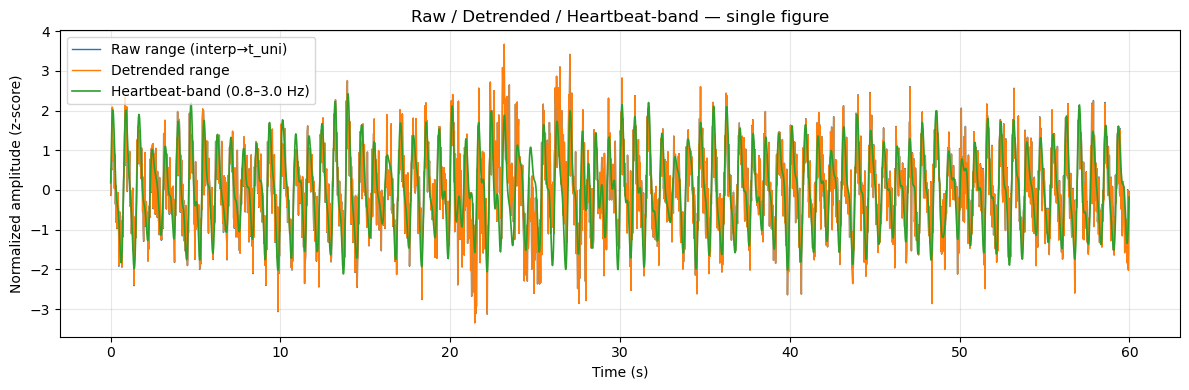

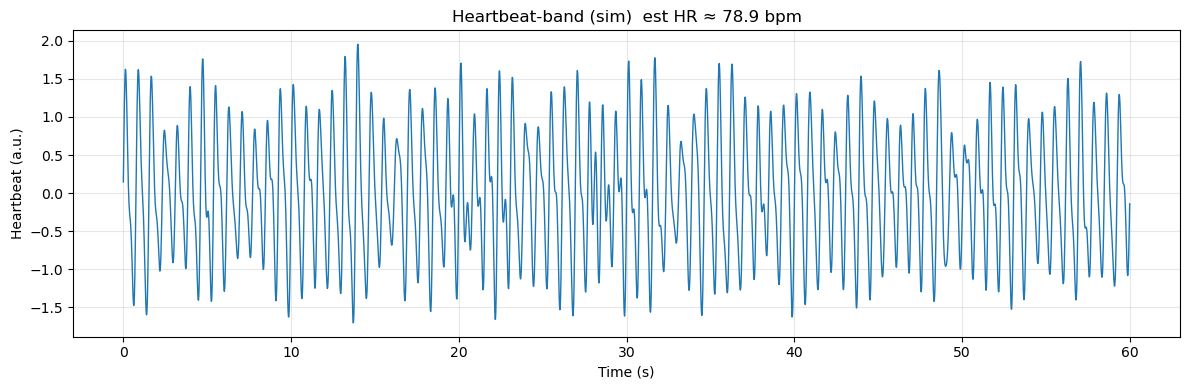

In [4]:
def process_simulated_summary(sim_summary, outdir="outputs", fs_hint=20.0):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 讀模擬 summary
    df = sim_summary["dataframe"]
    fs0 = float(sim_summary["fs_Hz"])
    t_raw = df["t_sec"].to_numpy()
    r_raw = df["heartbeat"].to_numpy()

    # 與真實流程一致：重取樣 → 去趨勢 → 帶通
    fs, t_uni, r_uni = resample_uniform(t_raw, r_raw, fs_hint=fs_hint or fs0)
    r_detr = signal.detrend(r_uni, type="linear")
    heart  = bandpass(r_detr, fs, 0.8, 3.0)

    # HR 估計
    hr_bpm = estimate_rate(heart, fs, 40, 180)

    # 組新的 summary（與真實版欄位相同）
    csv_path = os.path.join(outdir, "heart_rate_series_sim.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "range_detrended": r_detr,
        "heartbeat": heart
    })
    result_df.to_csv(csv_path, index=False)

    summary2 = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]),
        "fs_Hz": float(fs),
        "est_hr_bpm": float(hr_bpm) if np.isfinite(hr_bpm) else None,
        "csv": csv_path,
        "heartbeat_png": os.path.join(outdir, "heartbeat_sim.png"),
        "dataframe": result_df
    }

    # 圖：三聯圖 + 疊圖 + 心跳單圖
    plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir)
    plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir, normalize=True)

    plt.figure(figsize=(12,4))
    ttl = f"Heartbeat-band (sim)  est HR ≈ {hr_bpm:.1f} bpm" if np.isfinite(hr_bpm) else "Heartbeat-band (sim)"
    plt.plot(t_uni, heart, linewidth=1)
    plt.xlabel("Time (s)"); plt.ylabel("Heartbeat (a.u.)")
    plt.title(ttl); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(summary2["heartbeat_png"], dpi=200); plt.show()

    return summary2

# ===== 使用：把你的模擬 summary 丟進相同流程 =====
sim_summary2 = process_simulated_summary(summary, outdir="outputs")




Spectrum Analysis
Signal length: 3000 samples
Duration: 60.0 sec
Sampling rate: 50.0 Hz

📊 1. Computing frequency spectrum (FFT)...
   Dominant frequency: 78.0 bpm (1.300 Hz)
   Difference vs. peak detection: 0.9 bpm



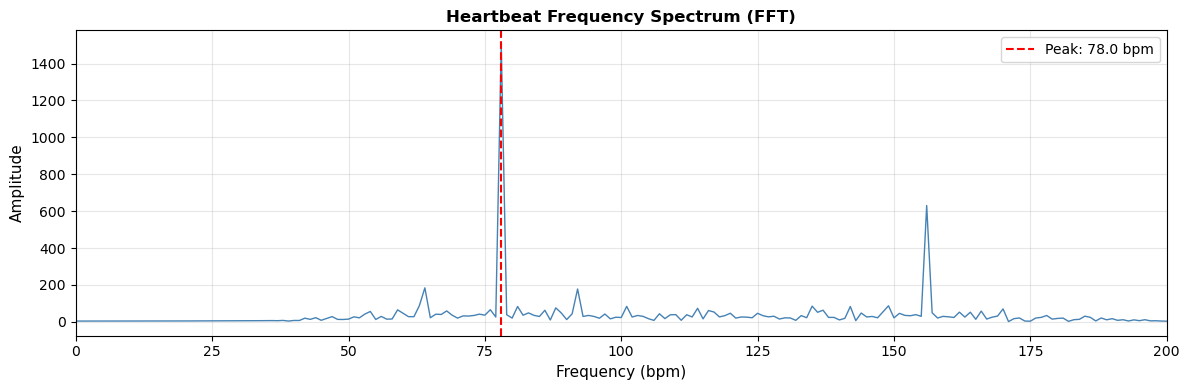


🔥 2. Computing spectrogram...
   Time resolution: 4.48 sec
   Frequency resolution: 11.72 bpm



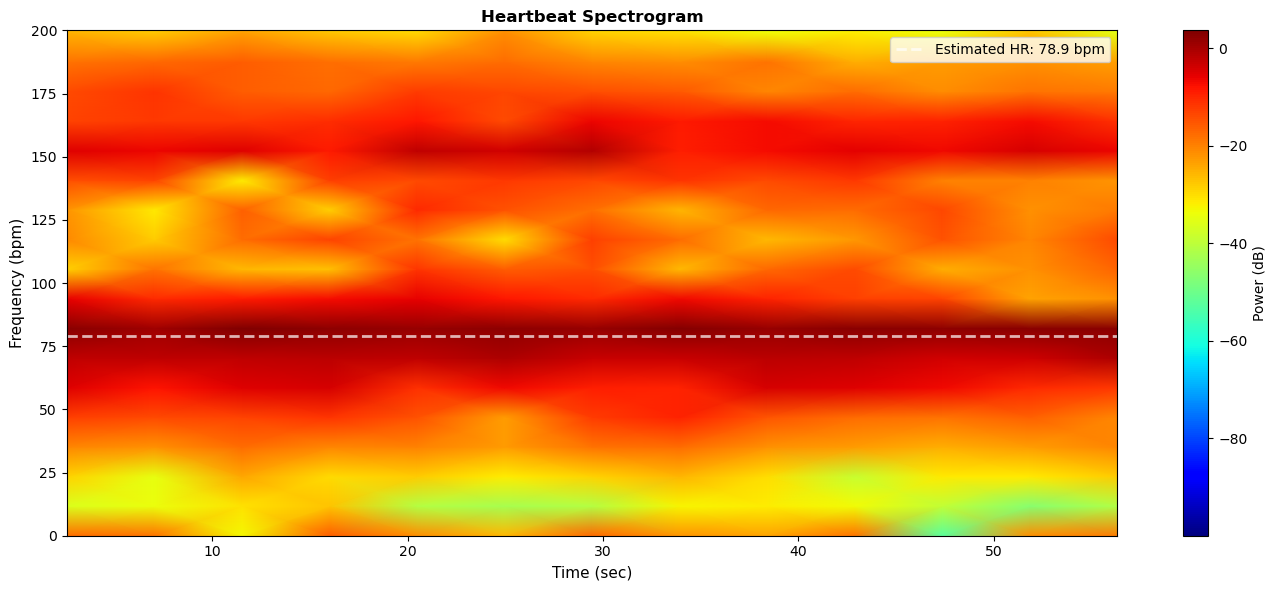


📈 3. Frequency band energy distribution...
   Very Low (<40 bpm)  :                                                      0.0%
   Low (40-60 bpm)     :                                                      0.5%
   Normal (60-100 bpm) : ████████████████████████████████████████            81.9%
   High (100-120 bpm)  :                                                      1.1%
   Very High (>120 bpm): ████████                                            16.5%



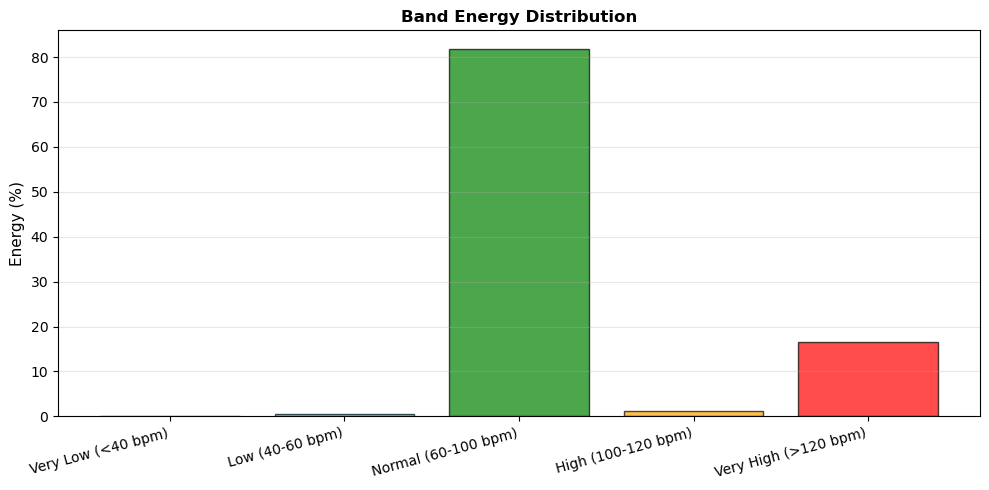


Analysis Complete!


In [5]:
"""
Spectrum Analysis Block - Run in another Notebook cell

Usage:
1. First run the main processing to get summary
2. Then run this block to perform spectrum analysis

Example:
    summary = process_vitals_folder("data/json_logs")
    # Then run the analysis below
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def analyze_spectrum(summary, save_plots=True, outdir=None):
    """
    Perform spectral analysis on processed heartbeat data
    
    Parameters:
    -----------
    summary : dict
        The result dictionary returned from process_vitals_folder()
    save_plots : bool
        Whether to save plots as PNG files
    outdir : str
        Directory for saving plots (default: same as main output)
    
    Returns:
    --------
    dict : dictionary containing spectrum analysis results
    """
    # Get data
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    heartbeat = df['heartbeat'].values
    fs = summary['fs_Hz']
    
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')
    
    print("="*60)
    print("Spectrum Analysis")
    print("="*60)
    print(f"Signal length: {len(heartbeat)} samples")
    print(f"Duration: {t_sec[-1] - t_sec[0]:.1f} sec")
    print(f"Sampling rate: {fs:.1f} Hz")
    print()
    
    # ==================== 1. FFT Spectrum ====================
    print("📊 1. Computing frequency spectrum (FFT)...")
    
    n = len(heartbeat)
    freq = np.fft.rfftfreq(n, 1/fs)  # frequency axis (Hz)
    fft_vals = np.abs(np.fft.rfft(heartbeat))
    freq_bpm = freq * 60  # convert Hz to bpm
    
    # Find dominant frequency
    idx_max = np.argmax(fft_vals[1:]) + 1
    dominant_freq_hz = freq[idx_max]
    dominant_freq_bpm = freq_bpm[idx_max]
    
    print(f"   Dominant frequency: {dominant_freq_bpm:.1f} bpm ({dominant_freq_hz:.3f} Hz)")
    print(f"   Difference vs. peak detection: {abs(dominant_freq_bpm - summary.get('est_hr_bpm', 0)):.1f} bpm")
    print()
    
    # Plot spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(freq_bpm, fft_vals, linewidth=1, color='steelblue')
    plt.axvline(dominant_freq_bpm, color='red', linestyle='--', 
                label=f'Peak: {dominant_freq_bpm:.1f} bpm')
    plt.xlabel("Frequency (bpm)", fontsize=11)
    plt.ylabel("Amplitude", fontsize=11)
    plt.title("Heartbeat Frequency Spectrum (FFT)", fontsize=12, fontweight='bold')
    plt.xlim([0, 200])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_plots:
        spectrum_path = f"{outdir}/spectrum.png"
        plt.savefig(spectrum_path, dpi=200)
        print(f"✅ Saved spectrum plot: {spectrum_path}")
    plt.show()
    
    # ==================== 2. Spectrogram ====================
    print("\n🔥 2. Computing spectrogram...")
    
    nperseg = min(256, len(heartbeat)//4)
    f, t_spec, Sxx = signal.spectrogram(heartbeat, fs, nperseg=nperseg)
    f_bpm = f * 60
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    
    print(f"   Time resolution: {t_spec[1] - t_spec[0]:.2f} sec")
    print(f"   Frequency resolution: {(f_bpm[1] - f_bpm[0]):.2f} bpm")
    print()
    
    plt.figure(figsize=(14, 6))
    im = plt.pcolormesh(t_spec, f_bpm, Sxx_db, shading='gouraud', cmap='jet')
    cbar = plt.colorbar(im, label='Power (dB)')
    plt.ylabel('Frequency (bpm)', fontsize=11)
    plt.xlabel('Time (sec)', fontsize=11)
    plt.title('Heartbeat Spectrogram', fontsize=12, fontweight='bold')
    plt.ylim([0, 200])
    
    if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
        plt.axhline(summary['est_hr_bpm'], color='white', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Estimated HR: {summary['est_hr_bpm']:.1f} bpm")
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_plots:
        spectrogram_path = f"{outdir}/spectrogram.png"
        plt.savefig(spectrogram_path, dpi=200)
        print(f"✅ Saved spectrogram plot: {spectrogram_path}")
    plt.show()
    
    # ==================== 3. Band Energy Distribution ====================
    print("\n📈 3. Frequency band energy distribution...")
    
    bands = {
        "Very Low (<40 bpm)": (0, 40),
        "Low (40-60 bpm)": (40, 60),
        "Normal (60-100 bpm)": (60, 100),
        "High (100-120 bpm)": (100, 120),
        "Very High (>120 bpm)": (120, 200)
    }
    
    band_energy = {}
    for band_name, (low, high) in bands.items():
        mask = (freq_bpm >= low) & (freq_bpm < high)
        energy = np.sum(fft_vals[mask]**2)
        band_energy[band_name] = energy
    
    total_energy = sum(band_energy.values())
    band_percentage = {k: (v/total_energy)*100 for k, v in band_energy.items()}
    
    for band_name, percentage in band_percentage.items():
        bar = "█" * int(percentage / 2)
        print(f"   {band_name:20s}: {bar:50s} {percentage:5.1f}%")
    print()
    
    plt.figure(figsize=(10, 5))
    colors = ['blue', 'cyan', 'green', 'orange', 'red']
    plt.bar(band_percentage.keys(), band_percentage.values(), 
            color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Energy (%)', fontsize=11)
    plt.title('Band Energy Distribution', fontsize=12, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    if save_plots:
        energy_path = f"{outdir}/energy_distribution.png"
        plt.savefig(energy_path, dpi=200)
        print(f"✅ Saved energy distribution plot: {energy_path}")
    plt.show()
    
    # ==================== Return ====================
    results = {
        "dominant_freq_bpm": float(dominant_freq_bpm),
        "dominant_freq_hz": float(dominant_freq_hz),
        "freq_bpm": freq_bpm,
        "fft_amplitude": fft_vals,
        "spectrogram_time": t_spec,
        "spectrogram_freq": f_bpm,
        "spectrogram_power": Sxx_db,
        "band_energy_percentage": band_percentage
    }
    
    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)
    
    return results


# ==================== 使用範例 ====================
# 在主程式執行後，使用此函數進行頻譜分析:
#
# summary = process_vitals_folder("data/json_logs")
spectrum_results = analyze_spectrum(sim_summary2, save_plots=False)
#
# # 存取頻譜資料
# print(f"主要頻率: {spectrum_results['dominant_freq_bpm']:.1f} bpm")
# print(f"正常心率能量佔比: {spectrum_results['band_energy_percentage']['正常 (60-100 bpm)']:.1f}%")

Cepstrum Analysis
Global HR estimate from cepstrum: 40.0 bpm
Track HR: mean=72.9 bpm, std=14.6 bpm
Quefrency search window: [0.300, 1.500] s  (HR 40-200 bpm)
Liftering: q < 0.100 s set to 0


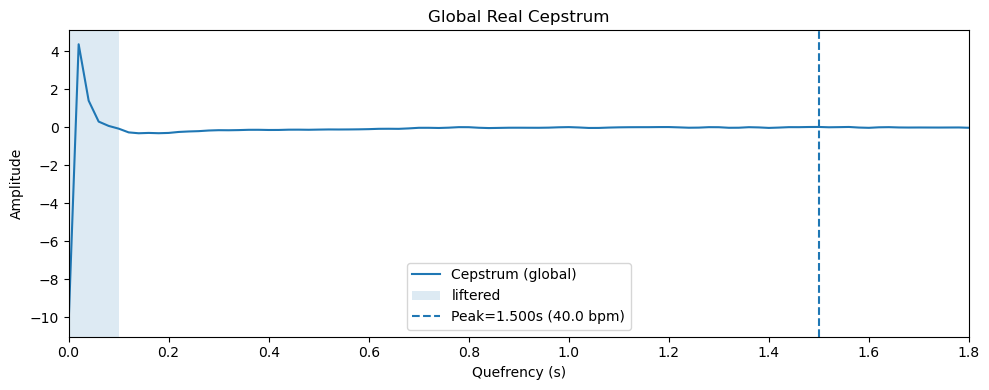

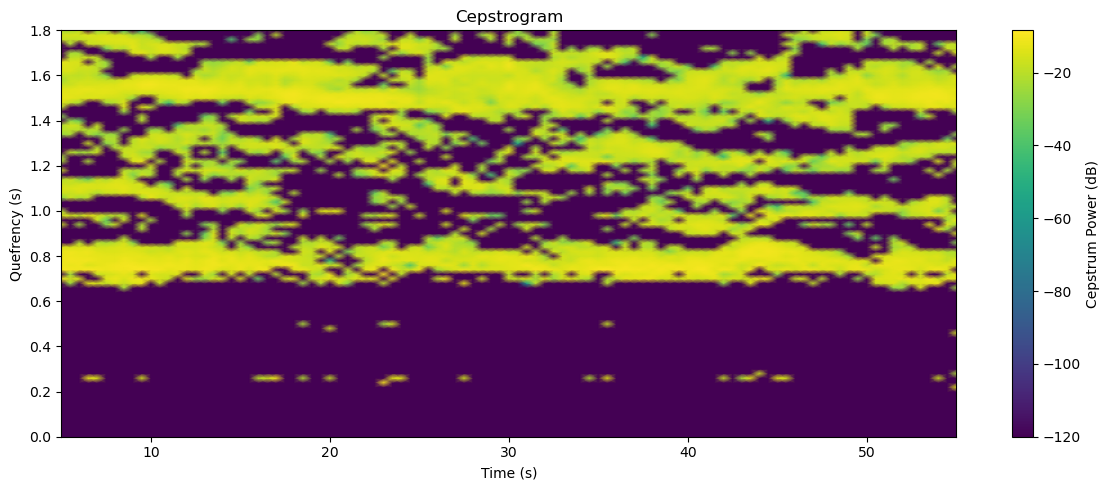

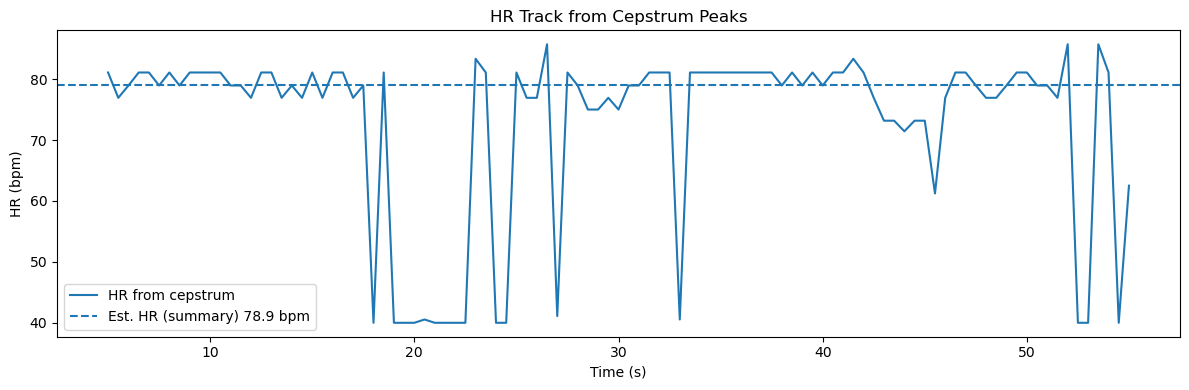

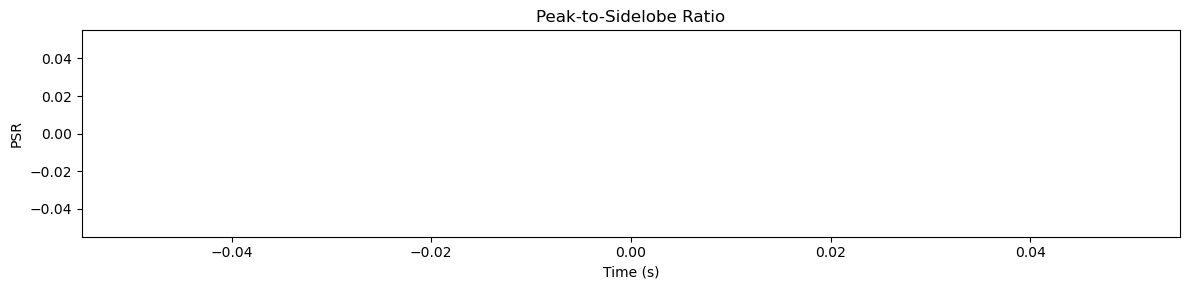

Sim global HR (cepstrum): 40.00000000000085


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def analyze_cepstrum(summary,
                     save_plots=True,
                     outdir=None,
                     hr_range_bpm=(40, 200),
                     lifter_q_sec=0.10,
                     win_sec=10.0,
                     hop_sec=0.5,
                     eps=1e-12):
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    N = len(x)
    hr_lo, hr_hi = hr_range_bpm
    q_lo = 60.0 / hr_hi
    q_hi = 60.0 / hr_lo

    # ---------- 全段倒頻譜（使用 N 長度窗，nfft 取 >= N 的 2 次方） ----------
    nfft_global = int(2 ** np.ceil(np.log2(max(16, N))))
    w_glob = signal.windows.hann(N, sym=False)
    Xg = np.fft.rfft(x * w_glob, n=nfft_global)
    Lg = np.log(np.maximum(np.abs(Xg), eps))
    c_global = np.real(np.fft.irfft(Lg, n=nfft_global))
    q_axis_g = np.arange(nfft_global) / fs

    # liftering 與 HR 搜尋窗
    c_glift = c_global.copy()
    c_glift[q_axis_g < lifter_q_sec] = 0.0
    mask_hr_q_g = (q_axis_g >= max(q_lo, lifter_q_sec)) & (q_axis_g <= q_hi)
    q_star_global = q_axis_g[mask_hr_q_g][np.argmax(c_glift[mask_hr_q_g])]
    hr_global = 60.0 / q_star_global

    # ---------- 滑動窗參數（不超過訊號長度） ----------
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    if win_len > N:
        win_len = N
    if hop_len < 1:
        hop_len = 1
    if win_len < 4:
        raise ValueError("win_sec too short given fs and signal length.")

    nfft_win = int(2 ** np.ceil(np.log2(max(16, win_len))))
    q_axis_w = np.arange(nfft_win) / fs
    mask_hr_q_w = (q_axis_w >= max(q_lo, lifter_q_sec)) & (q_axis_w <= q_hi)

    # ---------- 逐窗 cepstrogram 與 HR 軌跡 ----------
    w = signal.windows.hann(win_len, sym=False)
    centers, q_peaks, hr_track, conf_psr, frames = [], [], [], [], []

    for start in range(0, max(1, N - win_len + 1), hop_len):
        seg = x[start:start + win_len]
        if len(seg) < win_len:
            break
        Xw = np.fft.rfft(seg * w, n=nfft_win)
        Lw = np.log(np.maximum(np.abs(Xw), eps))
        c = np.real(np.fft.irfft(Lw, n=nfft_win))

        # liftering
        c[q_axis_w < lifter_q_sec] = 0.0

        # HR 對應 quefrency 主峰
        c_hr = np.where(mask_hr_q_w, c, 0.0)
        pk_idx = int(np.argmax(c_hr))
        q_pk = q_axis_w[pk_idx]
        hr = 60.0 / q_pk

        # PSR（主峰對旁瓣比）
        sl_mask = mask_hr_q_w.copy()
        win_ex = 2
        sl_mask[max(0, pk_idx - win_ex):min(len(sl_mask), pk_idx + win_ex + 1)] = False
        sidelobe = np.mean(c[sl_mask]) if np.any(sl_mask) else 0.0
        psr = (c[pk_idx] / (sidelobe + 1e-9)) if sidelobe > 0 else np.inf

        centers.append(t_sec[min(start + win_len // 2, N - 1)])
        q_peaks.append(q_pk)
        hr_track.append(hr)
        conf_psr.append(psr)
        frames.append(c)

    centers = np.asarray(centers)
    q_peaks = np.asarray(q_peaks)
    hr_track = np.asarray(hr_track)
    conf_psr = np.asarray(conf_psr)
    cepstrogram = np.stack(frames, axis=1) if len(frames) else np.zeros((nfft_win, 0))

    # ---------- 視覺化 ----------
    print("=" * 60)
    print("Cepstrum Analysis")
    print("=" * 60)
    print(f"Global HR estimate from cepstrum: {hr_global:.1f} bpm")
    if len(hr_track):
        print(f"Track HR: mean={np.nanmean(hr_track):.1f} bpm, std={np.nanstd(hr_track):.1f} bpm")
    print(f"Quefrency search window: [{q_lo:.3f}, {q_hi:.3f}] s  (HR {hr_lo}-{hr_hi} bpm)")
    print(f"Liftering: q < {lifter_q_sec:.3f} s set to 0")

    # 全段
    plt.figure(figsize=(10, 4))
    plt.plot(q_axis_g, c_global, label="Cepstrum (global)")
    plt.axvspan(0, lifter_q_sec, alpha=0.15, label="liftered")
    plt.axvline(q_star_global, linestyle='--', label=f'Peak={q_star_global:.3f}s ({hr_global:.1f} bpm)')
    plt.xlim(0, min(2.0, q_hi * 1.2))
    plt.xlabel("Quefrency (s)"); plt.ylabel("Amplitude"); plt.title("Global Real Cepstrum")
    plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{outdir}/cepstrum_global.png", dpi=200)
    plt.show()

    # cepstrogram
    if cepstrogram.shape[1] > 0:
        q_max_plot = min(2.0, q_hi * 1.2)
        q_mask_plot = q_axis_w <= q_max_plot
        C_db = 10 * np.log10(np.maximum(cepstrogram[q_mask_plot, :], eps))
        plt.figure(figsize=(12, 5))
        im = plt.pcolormesh(centers, q_axis_w[q_mask_plot], C_db, shading='gouraud')
        plt.colorbar(im, label='Cepstrum Power (dB)')
        plt.xlabel("Time (s)"); plt.ylabel("Quefrency (s)"); plt.title("Cepstrogram")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrogram.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(centers, hr_track, linewidth=1.5, label="HR from cepstrum")
        if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
            plt.axhline(summary['est_hr_bpm'], linestyle='--',
                        label=f"Est. HR (summary) {summary['est_hr_bpm']:.1f} bpm")
        plt.xlabel("Time (s)"); plt.ylabel("HR (bpm)"); plt.title("HR Track from Cepstrum Peaks")
        plt.legend(); plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/hr_track_cepstrum.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(centers, conf_psr, linewidth=1.2)
        plt.xlabel("Time (s)"); plt.ylabel("PSR"); plt.title("Peak-to-Sidelobe Ratio")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrum_confidence_psr.png", dpi=200)
        plt.show()

    return {
        "q_axis_global_sec": q_axis_g,
        "cepstrum_global": c_global,
        "q_star_global_sec": float(q_star_global),
        "hr_global_bpm": float(hr_global),
        "q_axis_win_sec": q_axis_w,
        "centers_sec": centers,
        "cepstrogram": cepstrogram,
        "q_peak_track_sec": q_peaks,
        "hr_track_bpm": hr_track,
        "confidence_psr": conf_psr,
        "params": {
            "fs_Hz": fs, "win_sec": win_sec, "hop_sec": hop_sec,
            "hr_range_bpm": hr_range_bpm, "lifter_q_sec": lifter_q_sec,
            "nfft_global": nfft_global, "nfft_win": nfft_win
        }
    }

# 後續與真實資料相同的分析
cep_results = analyze_cepstrum(sim_summary2, save_plots=False)
print("Sim global HR (cepstrum):", cep_results["hr_global_bpm"])

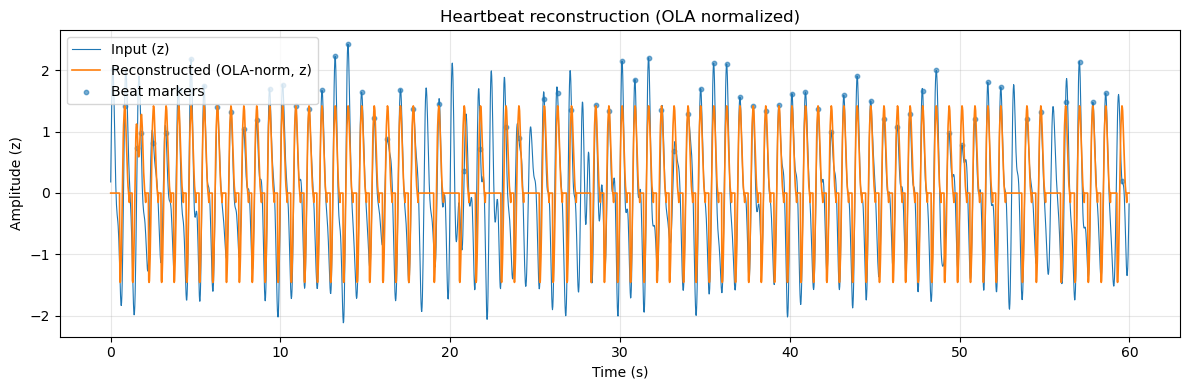

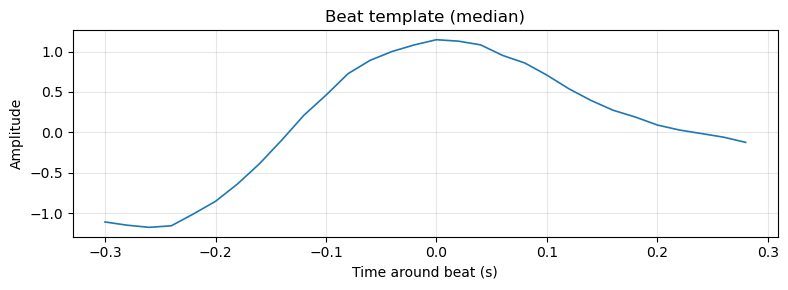

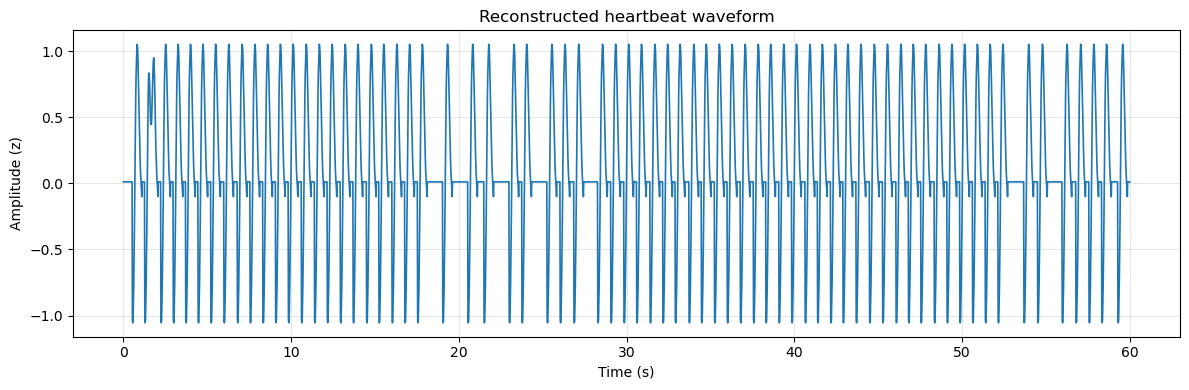

IBI mean (s): 0.8371830985915315 HR mean (bpm): 76.72120547907096


In [9]:
import numpy as np
from scipy import signal, interpolate
import matplotlib.pyplot as plt

def reconstruct_heartbeat_from_cepstrum(summary, cep_results,
                                        peak_search_halfwin=0.25,
                                        template_win=0.6,
                                        show_plots=True):
    """
    Reconstruct heartbeat via cepstrum-guided cycle-synchronous averaging (CSA).
    Applies OLA normalization to prevent inflated peaks.
    """
    df = summary['dataframe']
    t  = df['t_sec'].values
    y  = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    centers = np.asarray(cep_results["centers_sec"])
    q_pk    = np.asarray(cep_results["q_peak_track_sec"])  # IBI (s)
    if centers.size == 0 or q_pk.size == 0:
        raise ValueError("No cepstrum track. Run analyze_cepstrum first.")

    # --- build beat timeline from IBI track ---
    ibi_f = interpolate.interp1d(centers, q_pk, kind="linear",
                                 bounds_error=False, fill_value=(q_pk[0], q_pk[-1]))
    beats = [centers[0]]
    t_cur = centers[0]
    while t_cur < t[-1] - 0.3:
        t_cur = t_cur + float(ibi_f(t_cur))
        beats.append(t_cur)
    t_cur = centers[0]
    left = []
    while t_cur > t[0] + 0.3:
        t_cur = t_cur - float(ibi_f(t_cur))
        left.append(t_cur)
    beats = np.array(sorted(left[::-1] + beats))

    # --- local refinement around each predicted beat ---
    half_samp = max(1, int(round(peak_search_halfwin * fs)))
    adj_beats = []
    for tb in beats:
        i  = int(np.searchsorted(t, tb))
        i0 = max(0, i - half_samp); i1 = min(len(y)-1, i + half_samp)
        if i1 <= i0 + 2: 
            continue
        loc = i0 + np.argmax(y[i0:i1+1])
        adj_beats.append(t[loc])
    adj_beats = np.asarray(adj_beats)

    # --- CSA template ---
    L = int(round(template_win * fs))
    halfL = L // 2
    segs, idx_keep = [], []
    for tb in adj_beats:
        i  = int(np.searchsorted(t, tb))
        i0 = i - halfL; i1 = i - halfL + L
        if i0 < 0 or i1 > len(y): 
            continue
        segs.append(y[i0:i1]); idx_keep.append(i)
    if not segs:
        raise ValueError("No valid segments for CSA. Adjust template_win.")
    segs = np.stack(segs, axis=0)
    template = np.median(segs, axis=0)

    # --- OLA with normalization (fix #1) ---
    y_rec = np.zeros_like(y, float)
    w_ov  = signal.windows.hann(L, sym=False)
    w_sum = np.zeros_like(y, float)
    for i in idx_keep:
        i0 = i - halfL; i1 = i - halfL + L
        y_rec[i0:i1] += template * w_ov
        w_sum[i0:i1] += w_ov
    y_rec /= np.maximum(w_sum, 1e-12)  # normalize overlap

    # --- outputs and optional plots ---
    if show_plots:
        z  = (y - y.mean())/(y.std()+1e-12)
        zr = (y_rec - y.mean())/(y.std()+1e-12)  # align scale to input
        plt.figure(figsize=(12,4))
        plt.plot(t, z,  lw=0.8, label="Input (z)")
        plt.plot(t, zr, lw=1.2, label="Reconstructed (OLA-norm, z)")
        plt.scatter(adj_beats, np.interp(adj_beats, t, z), s=10, alpha=0.6, label="Beat markers")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude (z)")
        plt.title("Heartbeat reconstruction (OLA normalized)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(8,3))
        tt = np.arange(L)/fs - (halfL/fs)
        plt.plot(tt, template, lw=1.2)
        plt.xlabel("Time around beat (s)"); plt.ylabel("Amplitude")
        plt.title("Beat template (median)"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    adj_beats = np.sort(adj_beats)
    ibi = np.diff(adj_beats)
    hr_inst = 60.0/np.clip(ibi, 1e-6, None)

    return {
        "beat_times_sec": adj_beats,
        "ibi_sec": ibi,
        "hr_inst_bpm": hr_inst,
        "template": template,
        "template_time_sec": (np.arange(L)/fs - (halfL/fs)),
        "reconstructed": y_rec
    }

def plot_reconstructed_only(summary, rec, normalize=True):
    t = summary['dataframe']['t_sec'].values
    y = rec['reconstructed'].astype(float)
    if normalize:
        base = summary['dataframe']['heartbeat'].values
        y = (y - base.mean())/(base.std()+1e-12)
    plt.figure(figsize=(12,4))
    plt.plot(t, y, lw=1.2)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude" + (" (z)" if normalize else ""))
    plt.title("Reconstructed heartbeat waveform"); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
#cep_results = analyze_cepstrum(summary, save_plots=False)
rec = reconstruct_heartbeat_from_cepstrum(sim_summary2, cep_results, show_plots=True)
plot_reconstructed_only(summary, rec, normalize=True)
print("IBI mean (s):", rec["ibi_sec"].mean(), "HR mean (bpm):", rec["hr_inst_bpm"].mean())



In [ ]:
def collect_filter_results(summary, methods, use_agc=False, use_env_norm=False):
    df_src = summary['dataframe']
    t  = df_src['t_sec'].to_numpy()
    x  = df_src['heartbeat'].to_numpy().astype(float)  # 視作原始輸入
    fs = float(summary['fs_Hz'])

    # 原始去趨勢，供所有方法共用
    x_detr = signal.detrend(x, type='linear')

    results = []  # list of dicts

    for name, fn, kw in methods:
        y = fn(x, fs, **kw)  # 濾波輸出

        if use_agc:
            y = agc_rms(y, fs, target_rms=0.6, attack_ms=30, release_ms=200)
        if use_env_norm:
            y = envelope_norm(y, q=0.8)

        est = peak_hr_bpm(y, fs)
        est = float(est) if np.isfinite(est) else None

        df_out = pd.DataFrame({
            't_sec': t,
            'range_detrended': x_detr,  # 以原始x去趨勢對齊你的欄位命名
            'heartbeat': y              # 該方法濾後波
        })

        results.append({
            'name': name,
            'fs_Hz': fs,
            'est_hr_bpm': est,
            'dataframe': df_out
        })

    return results
results = collect_filter_results(summary, methods, use_agc=False, use_env_norm=False)
# 取第一個方法的 DataFrame:
df0 = results[0]['dataframe']
print(results[0]['name'])